**El Impacto De Las Condiciones Ambientales**

---


En la Calidad Del Agua Del Río De La Plata



[texto del vínculo](https://)

In [ ]:
#Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Pandas permite cargar, explorar y manipular datos en estructuras como los DataFrames, que son fundamentales para trabajar con información tabular. numpy se emplea para operaciones numéricas eficientes, como cálculos con arrays y manejo de valores nulos. Para la visualización de datos, se usa matplotlib.pyplot para crear gráficos básicos como líneas, barras o histogramas, mientras que seaborn facilita la generación de gráficos estadísticos más avanzados y estéticos, como mapas de calor o diagramas de caja.

Para el caso de  coordenadas geográficas, folium es útil para construir mapas interactivos que permiten representar datos espaciales. En cuanto a la preparación y modelado con machine learning, train_test_split de sklearn divide los datos en conjuntos de entrenamiento y prueba, lo que es esencial para validar modelos. StandardScaler se encarga de normalizar variables numéricas, LabelEncoder convierte variables categóricas en valores numéricos, y SimpleImputer permite imputar valores faltantes con distintas estrategias.

Finalmente, LinearRegression implementa un modelo de regresión lineal que se utiliza para predecir valores continuos. Para evaluar su rendimiento, se aplican métricas como el error cuadrático medio (mean_squared_error) y el coeficiente de determinación (r2_score), que indican la precisión del modelo al predecir los datos.

**Zona de Estudio con GEE**

Utiliza imagenes Sentinel-2 corregido atmosféricamente (COPERNICUS/S2_SR).

Filtra imágenes con menos del 20% de nubes

Selecciona la estacion por año (primavera e invierno)

Primero se debe habilitar una APi de GEE version gratuita, luego se procede a armar un proyecto o carpeta en GEE y se habilita para despues seguir con el codigo en Colab

In [ ]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet

import ee
ee.Authenticate()  # ← Esto abre un enlace para autorizar tu cuenta
ee.Initialize(project='mentorias-463215')  # Solo después de autenticar
ee.Initialize(project='mentorias-463215')  # Reemplazado con mi ID de proyecto

# Punto central: Franja costera del Río de La Plata
punto = ee.Geometry.Point([-58.4464023, -34.5375533])
zona = punto.buffer(1000).bounds()

# Función para obtener una imagen limpia por estación y año
def obtener_imagen(estacion, fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)

    vis_params = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}  # RGB
    return coleccion.visualize(**vis_params).set({'title': estacion})

# Crear diccionario con las estaciones
imagenes = {
    'Invierno 2021': obtener_imagen('Invierno 2021', '2021-06-21', '2021-09-21'),
    'Primavera 2021': obtener_imagen('Primavera 2021', '2021-09-22', '2021-12-20'),
    'Invierno 2022': obtener_imagen('Invierno 2022', '2022-06-21', '2022-09-21'),
    'Primavera 2022': obtener_imagen('Primavera 2022', '2022-09-22', '2022-12-20'),
}

# Crear mapa
m = geemap.Map(center=[-34.5375533, -58.4464023], zoom=13)

# Agregar capas al mapa
for nombre, imagen in imagenes.items():
    m.addLayer(imagen, {}, nombre)

m.add_legend(title="Estaciones", labels=list(imagenes.keys()), colors=['#999999']*4)
m


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[-34.5375533, -58.4464023], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

Las imágenes satelitales correspondientes a invierno y primavera de los años 2021 y 2022 permiten evidenciar condiciones ambientales superficiales en distintas estaciones y años. Las variaciones en la coloración del agua observadas en las escenas pueden reflejar diferencias en la turbidez, en la presencia de sedimentos en suspensión o incluso en posibles floraciones algales, todos ellos considerados indicadores indirectos del estado de la calidad del agua. Además, el contraste entre áreas ribereñas vegetadas y zonas construidas permite inferir el grado de permeabilidad del entorno y su influencia en los procesos de escurrimiento y arrastre de contaminantes hacia el río.

Estas imágenes también permiten interpretar procesos ambientales que afectan directamente la calidad del agua. Por ejemplo, un aumento del verdor costero durante la primavera podría asociarse a una mayor actividad agrícola o a un incremento en la escorrentía de fertilizantes, mientras que la presencia de tonalidades marrones u opacas en el cuerpo de agua puede estar relacionada con una mayor carga de sedimentos o materia orgánica en suspensión, resultado de fenómenos como la erosión del suelo, precipitaciones intensas o vertidos cloacales.

Finalmente, la comparación entre años permite detectar patrones interanuales. Si en una misma estación se observa una mayor degradación visual del agua en un año respecto a otro, es posible vincular esa diferencia con condiciones climáticas particulares (como sequías o lluvias extremas) o con transformaciones en el uso del suelo del entorno inmediato al cauce.

**Descripcion del dataset**

Al analizar el dataset Conexiones_Transparentes.csv, se observó primero su dimensión general, es decir, cuántas filas y columnas contiene.Se identificó  613 registros distribuidos en 45 columnas. Esto permitió tener una idea inicial del volumen de datos con los que se va a trabajar. Luego, se revisaron los tipos de datos de cada variable, lo cual permite entender si se trata de valores numéricos, texto, fechas u otro tipo de información, y así anticipar qué tipo de análisis será necesario en cada caso.

Finalmente, se visualizaron las primeras filas del dataset, lo que sirvió para conocer cómo están estructurados los datos, si los nombres de las columnas son claros, si hay valores atípicos o mal cargados a simple vista, y empezar a identificar patrones o variables relevantes.

In [ ]:
# Configuracion de pandas

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)

# Descripcion del dataset
print("Dimensiones del dataset:")
print(df.shape)

print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras filas del dataset:")
display(df.head())

Dimensiones del dataset:
(613, 45)

Tipos de datos:
orden                                                                               float64
sitios                                                                               object
codigo                                                                               object
fecha                                                                                object
año                                                                                  object
campaña                                                                              object
tem_agua                                                                             object
tem_aire                                                                             object
od                                                                                   object
ph                                                                                   object
olores                      

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
0,23.0,Polo Petroquímico Dock Sud,AV051,24/2/2021,2021.0,verano,25.3,no se midió,4.77,6.61,Ausencia,Ausencia,Ausencia,Ausencia,2000,1320,450,4.3,0.36,1,0.44,<2.0,<30,45,<100,<5.0,<0.001,0,<0.15,45,Muy deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23.0,Polo Petroquímico Dock Sud,AV051,19/5/2021,2021.0,otoño,16.2,14.5,5.95,7.79,Ausencia,Ausencia,Ausencia,Ausencia,5000,2400,60,3.6,3.3,0.33,0.33,6,5.2,<30,80,<100,<0.005,<0.001,<10.000,48,Muy deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23.0,Polo Petroquímico Dock Sud,AV051,25/8/2021,2021.0,invierno,15.1,12.8,3.76,7.11,Ausencia,Ausencia,Ausencia,Ausencia,40000,3000,20,2.2,2,0.61,0.56,3.3,<30,13,<100,<0.005,<0.001,<0.010,<0.20,40,Extremadamente deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.0,Polo Petroquímico Dock Sud,AV051,27/10/2021,2021.0,primavera,23.9,28,4.59,6.76,Ausencia,Ausencia,Ausencia,Ausencia,2000,100,100,<2.0,1.5,0.25,0.29,2.4,52,15,<100,<0.005,<0.001,<0.01,<0.20,52,Muy deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.0,Arroyo Sarandí,AV052,24/2/2021,2021.0,verano,25.5,no se midió,3.22,6.87,Ausencia,Ausencia,Ausencia,Ausencia,10000,3200,600,4,1.6,0.98,0.46,6.4,<30,32,<100,<5.0,<0.001,0.005,<0.15,39,Extremadamente deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Al revisar los tipos de datos, la mayoría de las columnas están clasificadas como objetos (object), lo que indica que contienen datos categóricos o texto.

**Analisis exploratorio**

La información general del dataset muestra un total de 613 registros distribuidos en 45 columnas. Sin embargo, no todas las columnas tienen la misma cantidad de datos completos. Algunas presentan valores faltantes, como es el caso de tem_aire , lo que indica que ciertas observaciones no fueron medidas o registradas en todas las campañas o estaciones.

Además, se nota que la mayoría de las columnas están tipadas como object, incluso aquellas que deberían contener valores numéricos, como od, nitrato_mg_l, entre otras. Esto sugiere que probablemente haya que hacer una conversión de tipos para poder analizarlas correctamente, ya sea por el uso de comas como separadores decimales o por la presencia de caracteres no numéricos.

Esta revisión general  permite detectar desde el inicio qué variables requieren limpieza o transformación antes de cualquier análisis o modelado más avanzado. También da una idea del nivel de completitud de los datos y de los posibles desafíos que habrá que enfrentar en el preprocesamiento.

In [ ]:
# Informacion general
print("\nInformación general:")
df.info()


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 45 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   orden                                                                             589 non-null    float64
 1   sitios                                                                            589 non-null    object 
 2   codigo                                                                            613 non-null    object 
 3   fecha                                                                             589 non-null    object 
 4   año                                                                               573 non-null    object 
 5   campaña                                                                           573 non-n

En la tabla cada fila representa una columna del DataFrame. Esto significa lo siguiente:

Column: el nombre de la columna, por ejemplo, orden, sitios, codigo, etc.

Non-Null Count: cantidad de valores que no están vacíos (no son NaN) en esa columna. Por ejemplo, orden tiene 589 valores no nulos, lo que implica que 24 filas tienen datos faltantes en esa columna (613 - 589 = 24).

Dtype: el tipo de dato que tiene esa columna:

- float64: números decimales.
- object: generalmente texto o una mezcla de tipos (podrían ser números como texto, fechas mal interpretadas, etc.).

**Procesamiento de datos**

Indica cuántos registros están completamente duplicados, es decir, que repiten todos los valores en todas sus columnas. Este paso permite asegurarse de que no haya información repetida que pueda sesgar los análisis o inflar resultados sin aportar datos nuevos. Saber si existen duplicados también ayuda a decidir si es necesario limpiar el dataset antes de seguir trabajando.

In [ ]:
# Datos duplicados
print("\nCantidad de datos duplicados:")
print(df.duplicated().sum())


Cantidad de datos duplicados:
18


**Identificacion de datos duplicados**

Este analisis permite identificar si existen registros exactamente repetidos dentro del dataset. Primero se confirmó cuántas filas completas están duplicadas, lo que indica que ciertos registros fueron cargados más de una vez sin ningún cambio en ninguna de sus columnas. Estas filas duplicadas fueron mostradas en una tabla para poder inspeccionarlas visualmente y decidir si conviene eliminarlas en el preprocesamiento.

Luego se revisó cada columna por separado para detectar si contiene valores repetidos, aunque no necesariamente en filas idénticas. Esto ayuda a identificar, por ejemplo, si hay valores que se repiten demasiado en campos que deberían ser únicos (como una estación de monitoreo o una fecha) o si hay agrupamientos naturales que podrían aprovecharse durante el análisis.

In [ ]:
# Filas duplicadas
print("\nCantidad de filas duplicadas:")
print(df.duplicated().sum())

print("\nFilas duplicadas:")
duplicadas = df[df.duplicated()]
display(duplicadas)

# Valores duplicados de cada columna
print("\nColumnas con valores duplicados:")
for col in df.columns:
    valores_duplicados = df[col][df[col].duplicated()].unique()
    if len(valores_duplicados) > 0:
        print(f"\nColumna: {col}")
        print(f"Valores duplicados: {valores_duplicados}")


Cantidad de filas duplicadas:
18

Filas duplicadas:


,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
224,NaN,NaN,CA CU01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ecológica ciudad universitaria costane...,-34.535.878,-58.445.933,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,NaN,NaN,CA CU02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: boca de entrada ...,-34.537.272,-58.448.339,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,CA CU03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,CA CU04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: humedal central ...,-34.539.667,-58.443.781,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,CA CU05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: dique sur subsis...,-34.540.675,-584.419,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,NaN,NaN,EN AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ensenada,Boca cerrada (res. extra nat. punta Lara),-34.781.253,-58.008.481,63.997,37.375,"""siderúrgica y refineria de petroleo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,CA CU01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ecológica ciudad universitaria costane...,-34.535.878,-58.445.933,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,NaN,NaN,CA CU02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: boca de entrada ...,-34.537.272,-58.448.339,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,NaN,NaN,CA CU03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,NaN,NaN,CA CU04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: humedal central ...,-34.539.667,-58.443.781,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columnas con valores duplicados:

Columna: orden
Valores duplicados: [23. 24. 26. 22. 25. 39. 37. 41. 42. 40. 38. 31. 30. 32. nan 18. 19. 20.
 21. 33. 34. 35. 36. 27. 28. 29. 10. 11. 12. 14. 13.  1.  3.  4.  5.  6.
  2.  7.  8.  9. 17. 16. 15. 43.]

Columna: sitios
Valores duplicados: ['Polo Petroquímico Dock Sud' 'Arroyo Sarandí' 'Arroyo Santo Domingo'
 'Escollera de Propaneros' 'Costa de Villa Domínico     '
 'Playa La Bagliardi' 'Balneario Palo Blanco' 'Playa La Balandra'
 'Balneario Municipal' 'Diagonal 66 (descarga cloaca)'
 'Puerto Trinidad calle 47' 'Calle 14 y Costa - Salida cloaca'
 'Costanera Hudson Calle 63' nan 'Parque de los Niños'
 'Costanera Norte - Espigón Abanico' 'Club de Pescadores'
 'Reserva Ecológica Costanera Sur - Playita' 'Camping Eva Perón'
 'Toma de agua Club de Pesca' 'Arroyo El Gato'
 'Ensenada Prefectura Isla Santiago' 'Espora 400 m' 'Náutico 400 m'
 'Pejerrey Club 400 m' 'Del Arca' 'Espigón La Farola' 'Reserva Ecológica'
 'Perú Puente' 'Playa Espigón de P

**Valores faltantes - Datos vacios o con NaN**

Este código analiza un DataFrame y genera una tabla resumen que muestra cuántos datos faltantes tiene cada columna. Lo que hace es calcular cuántos valores son NaN, cuántos son cadenas vacías "", y luego suma ambos para obtener el total de faltantes. A partir de eso, también calcula el porcentaje que representan esos valores faltantes en relación al total de filas del DataFrame.

El resultado es una tabla con cuatro columnas: una con la cantidad de valores NaN, otra con la cantidad de celdas vacías como texto, otra con el total combinado de valores faltantes, y una última con el porcentaje de datos incompletos. Esta tabla se muestra con un estilo visual que aplica una escala de color que va del verde al azul para resaltar visualmente las columnas con más valores faltantes. Cuanto más alto es el valor, más oscuro es el color de fondo.

Además, la columna que muestra el porcentaje de faltantes aplica un formato especial: si ese porcentaje supera el 50%, el valor aparece resaltado en rojo y en negrita. Esto permite identificar rápidamente qué variables están críticamente incompletas y podrían requerir limpieza o eliminación.


In [ ]:
# Calcular valores faltantes
nan_counts = df.isna().sum()
empty_counts = (df == "").sum()
total_faltantes = df.isna() | (df == "")
total_missing_counts = total_faltantes.sum()
porcentaje = (total_missing_counts / len(df) * 100)

# Crear resumen
summary = pd.DataFrame({
    "Valores NaN": nan_counts,
    "Vacíos ('')": empty_counts,
    "Total Faltantes": total_missing_counts,
    "Porcentaje (%)": porcentaje
})

# Función para resaltar en rojo si el porcentaje es crítico (> 50%)
def resaltar_porcentaje(col):
    return ['color: red; font-weight: bold' if v > 50 else '' for v in col]

# Aplicar estilos
summary.style\
    .background_gradient(cmap="BuGn")\
    .format({"Porcentaje (%)": "{:.2f}"})\
    .apply(resaltar_porcentaje, subset=["Porcentaje (%)"])\
    .set_caption("Resumen de Datos Faltantes")\
    .set_properties(**{'text-align': 'center'})

,Valores NaN,Vacíos (''),Total Faltantes,Porcentaje (%)
orden,24,0,24,3.92
sitios,24,0,24,3.92
codigo,0,0,0,0.00
fecha,24,0,24,3.92
año,40,0,40,6.53
campaña,40,0,40,6.53
tem_agua,41,0,41,6.69
tem_aire,52,0,52,8.48
od,41,0,41,6.69
ph,46,0,46,7.50


**Resumen estadistico**

Al ejecutar el resumen estadístico del dataset, el objetivo principal es obtener una visión general cuantitativa y cualitativa de cada variable. Esto incluye información como: la cantidad de datos disponibles, los valores únicos, la moda, la media, la mediana, los cuartiles, el mínimo y el máximo, así como la desviación estándar para las variables numéricas.

Este análisis permite identificar rápidamente la distribución y características principales de los datos, detectar posibles valores atípicos, entender la diversidad o repetición en variables categóricas, y evaluar la calidad y completitud de la información.

In [ ]:
# Resumen estadistico
resumen = df.describe(include='all')

# Renombrar índices al español
resumen.rename(index={
    'count': 'Cantidad de datos',
    'unique': 'Valores únicos',
    'top': 'Valor más frecuente',
    'freq': 'Frecuencia',
    'mean': 'Promedio',
    'std': 'Desviación estándar',
    'min': 'Mínimo',
    '25%': 'Percentil 25',
    '50%': 'Mediana (Percentil 50)',
    '75%': 'Percentil 75',
    'max': 'Máximo'
}, inplace=True)

# Función para alternar colores en filas
def estilo_tabla(s):
    colores = ['#f9f9f9', '#e0f7fa']
    return ['background-color: {}'.format(colores[i % 2]) for i in range(len(s))]

# Aplicar estilo y mostrar
styled_resumen = resumen.style.apply(estilo_tabla, axis=0)\
                             .set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[['Cantidad de datos', 'Valores únicos', 'Frecuencia', 'Desviación estándar'], :])\
                             .set_table_styles([{
                                'selector': 'th',
                                'props': [('background-color', '#00796b'), ('color', 'white'), ('font-weight', 'bold')]
                             }])

print("\nResumen estadístico")
display(styled_resumen)


Resumen estadístico


,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
Cantidad de datos,589.000000,589,613,589,573,573,572,561,572,567,574,574,574,574,571,573,573,573,573,572,573,571,574,574,574,573,574,572,573,560,544,290,290,290,290,290,290,290,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
Valores únicos,nan,45,50,20,6,8,158,64,373,240,13,15,12,13,175,176,173,177,197,123,103,119,97,178,34,51,21,229,46,61,11,10,25,25,25,10,10,9,nan,nan,nan,nan,nan,nan,nan
Valor más frecuente,nan,Playa La Balandra,BS093,23/8/2023,2023.0,invierno,no se midió,no se midió,no se midió,no se midió,Ausencia,Ausencia,Ausencia,Ausencia,no se midió,100,no se midió,<2.0,<0.05,no se midió,s/i,<2.0,<30,no se midió,<0.10,<0.005,<0.001,<10.00,<0.15,37,Extremadamente deteriorada,CABA,Arroyo Santo Domingo,-34.662.789,-58.296.669,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",nan,nan,nan,nan,nan,nan,nan
Frecuencia,nan,15,15,43,169,127,41,48,45,44,435,434,460,365,29,39,29,36,27,33,43,76,202,26,329,311,372,75,281,37,321,62,14,14,14,62,62,62,nan,nan,nan,nan,nan,nan,nan
Promedio,21.539898,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.250000,3.833333,1.833333,4.250000,4.000000,3.833333,3.833333
Desviación estándar,12.159115,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.743250,1.679987,1.629322,1.926027,1.920579,1.913290,1.868961
Mínimo,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
Percentil 25,11.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.750000,2.750000,0.000000,2.750000,2.750000,2.750000,2.750000
Mediana (Percentil 50),22.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.500000,4.000000,1.500000,4.000000,4.500000,3.500000,4.000000
Percentil 75,32.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.000000,5.000000,3.250000,6.000000,5.250000,5.250000,5.250000


Al observar el resumen estadístico del dataset, se puede observar que algunas columnas tienen una cantidad menor de datos registrados, lo que indica la presencia de valores faltantes. Por ejemplo, mientras que variables como el código o la fecha cuentan con casi todos los datos, otras como las mediciones químicas o físicas tienen menos registros completos.

Se destaca que algunas columnas contienen valores categóricos, como el nombre de los sitios, la campaña o la estación del año, donde el valor más frecuente se repite muchas veces, reflejando condiciones comunes o datos estándar (como “invierno” o “Ausencia” en ciertas mediciones).

En las columnas numéricas, el promedio, la desviación estándar y los percentiles muestran la distribución de los datos cuando están presentes, pero muchos valores son nulos, lo que implica que será necesario realizar un tratamiento especial para estos datos faltantes antes de hacer un análisis más profundo.

**Distribucion de las variables**

Los gráfico de histogramas muestra cómo se distribuyen los valores de cada variable numérica en el dataset. Permite visualizar si los datos están concentrados alrededor de ciertos rangos, si presentan sesgos hacia un extremo, o si existen valores atípicos o outliers. Además, ayuda a identificar la forma de la distribución por ejemplo, si es normal, sesgada o multimodal.

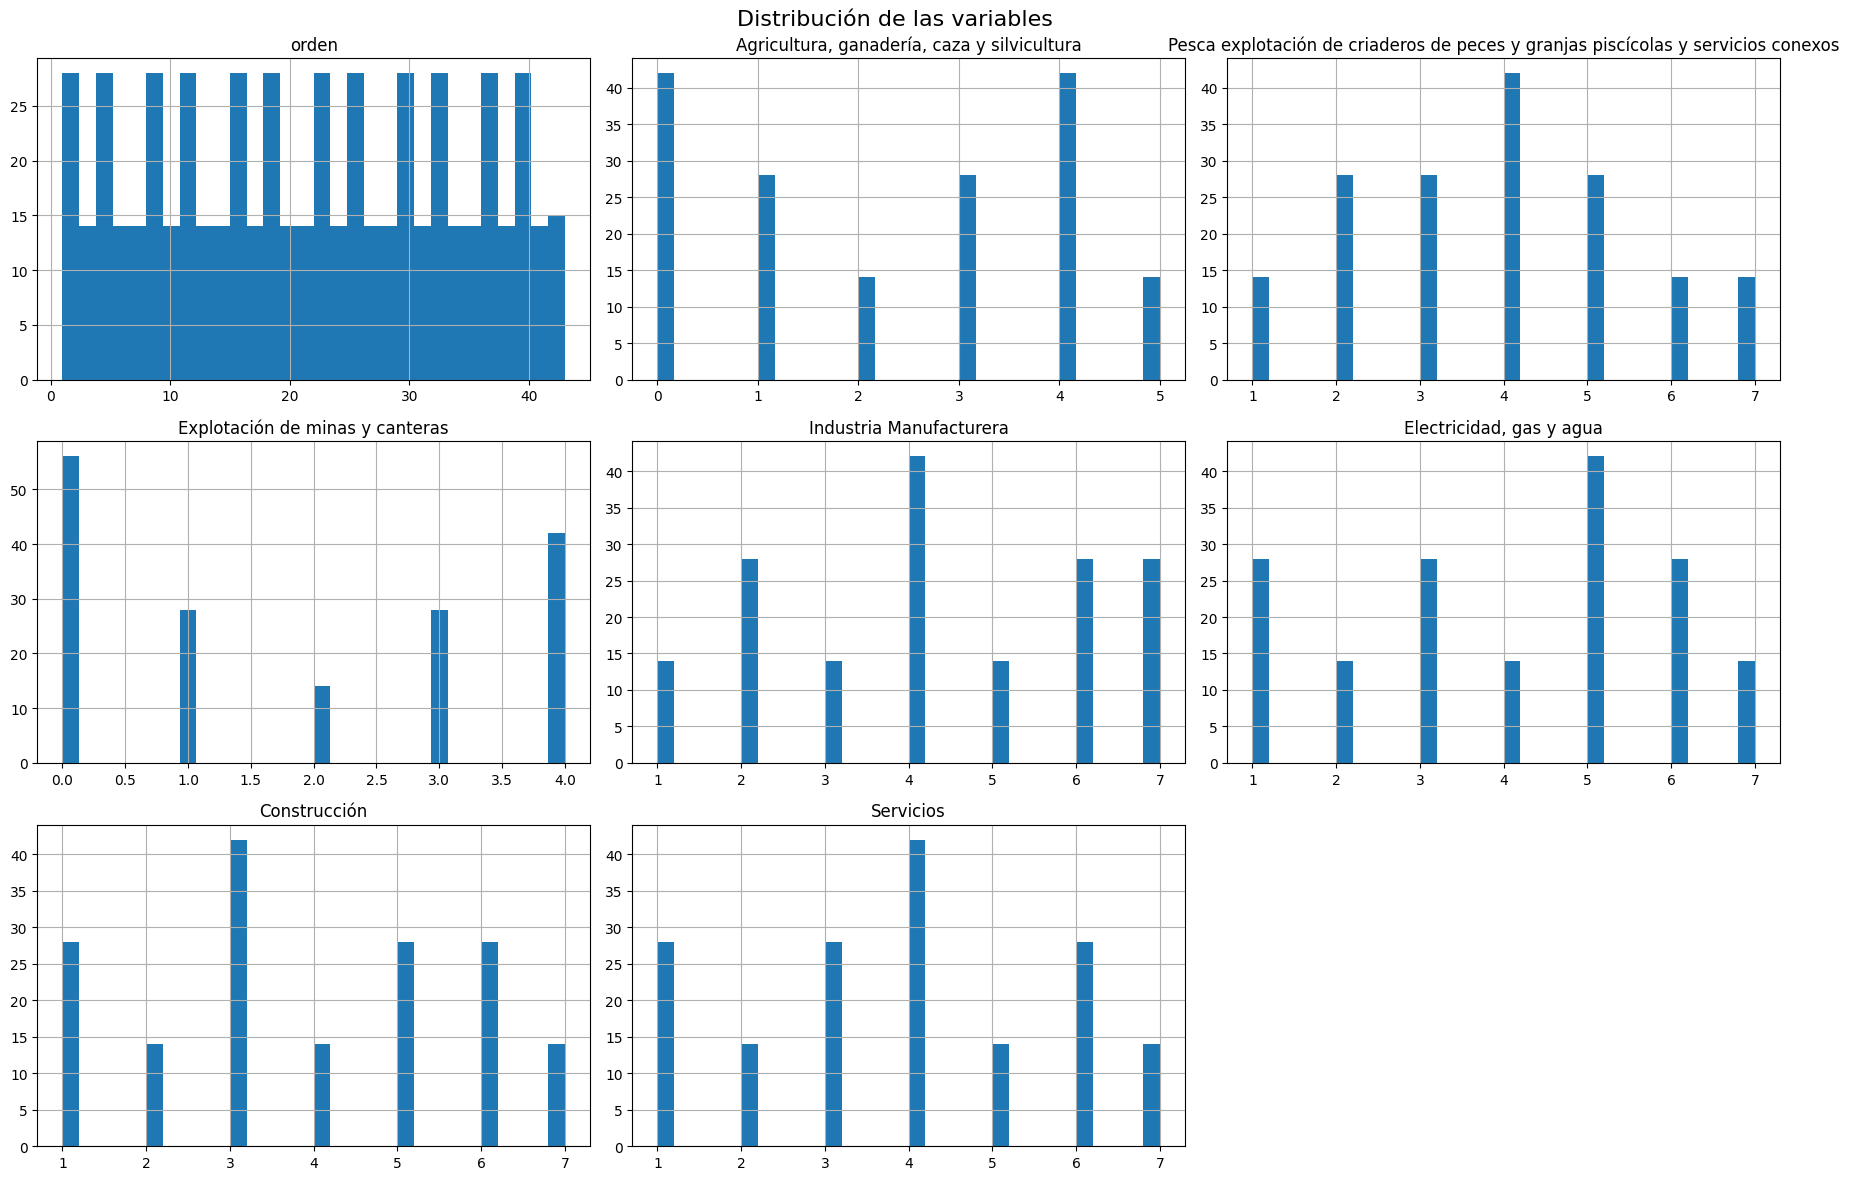

In [ ]:
# Distribucion de variables
df.hist(bins=30, figsize=(18, 12))
plt.suptitle("Distribución de las variables", fontsize=16)
plt.tight_layout()
plt.show()

En Agricultura, ganadería, caza y silvicultura, las categorías 0 y 4 son las más frecuentes, con una presencia destacada también de las categorías 1 y 3. Esto indica que ciertas actividades o subsectores dentro de esta área son más comunes en los datos.

En el sector de Pesca y explotación de criaderos de peces y granjas piscícolas, la categoría 4 tiene la mayor frecuencia, seguida por las categorías 2, 3 y 5, mostrando una concentración significativa en estas actividades específicas.

Para la Explotación de minas y canteras, la categoría 0 es la que domina ampliamente, con la categoría 4 también teniendo un peso considerable. Esto refleja una concentración en ciertas actividades mineras o extractivas dentro del dataset.

En la Industria manufacturera, la categoría 4 es claramente la más frecuente, seguida por las categorías 2, 6 y 7, lo que señala que una parte importante de la industria representada se centra en esos subsectores.

En el sector de Electricidad, gas y agua, la categoría 5 destaca por su alta frecuencia, con presencia moderada de las categorías 1, 3 y 6, reflejando la distribución de actividades en servicios públicos.

En Construcción, la categoría 3 tiene la mayor frecuencia, seguida por las categorías 1, 5 y 6, mostrando una variedad de subsectores con una concentración significativa en ciertos tipos de construcción.

Finalmente, en Servicios, la categoría 4 es la más común, con las categorías 1, 3 y 6 también presentes en proporciones relevantes, indicando la diversidad dentro del sector servicios y ciertos subgrupos predominantes.





**Datos atipicos**

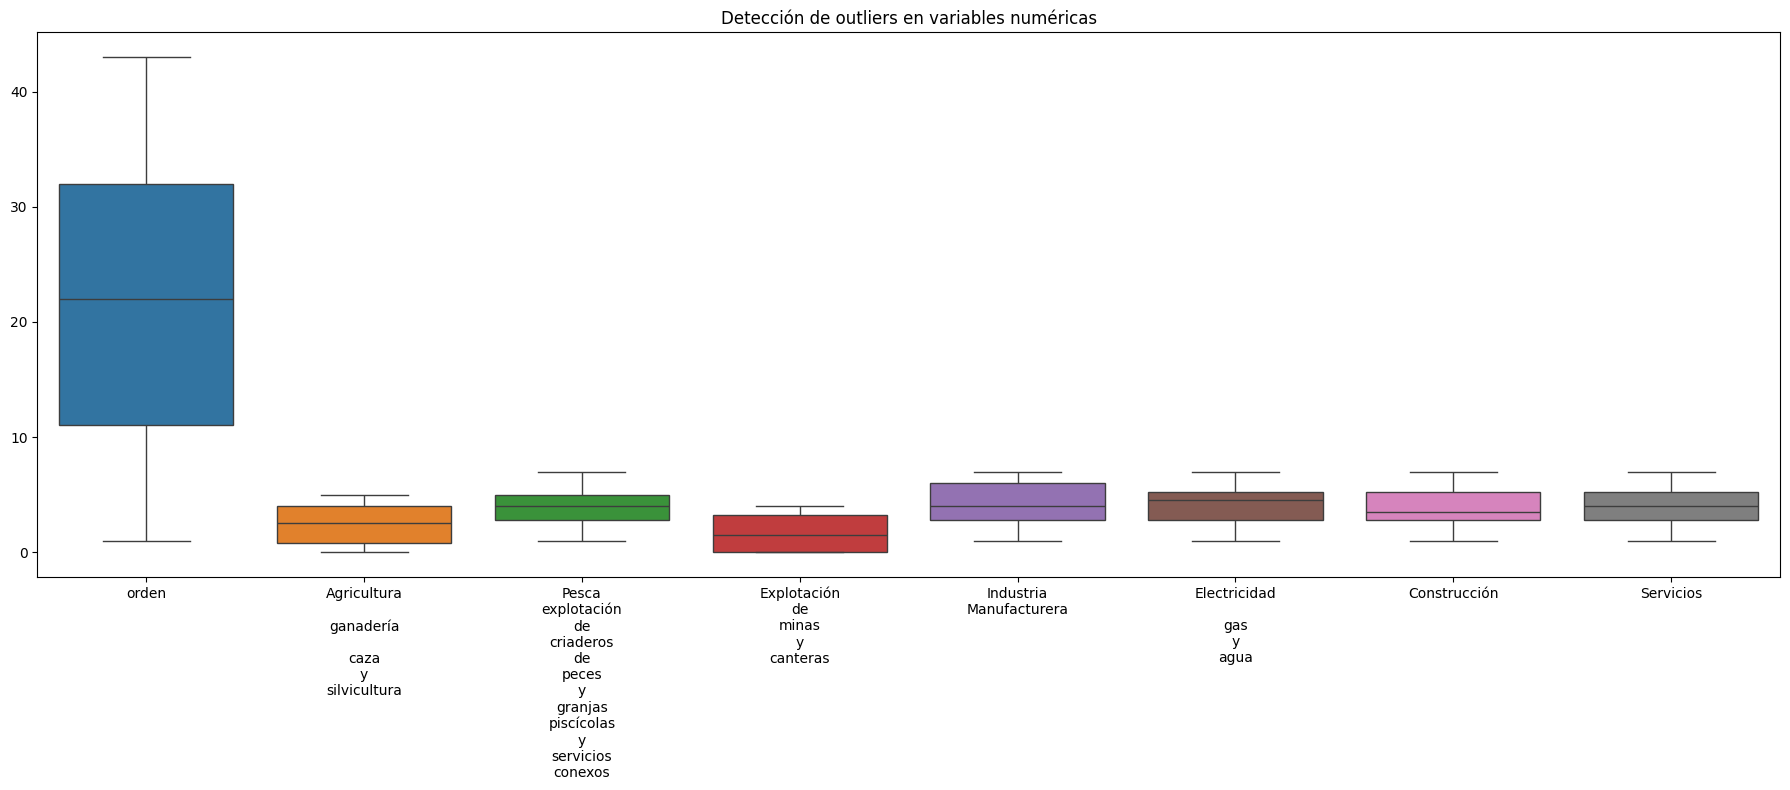

In [ ]:
# Outliers
plt.figure(figsize=(18, 8))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Detección de outliers en variables numéricas")
# Lista original de etiquetas del eje X
labels = df.select_dtypes(include=np.number).columns.tolist()

# Modificar etiquetas insertando saltos de línea
labels_wrapped = [
    label.replace(" ", "\n").replace(",", "\n")
    for label in labels
]

plt.xticks(ticks=range(len(labels_wrapped)), labels=labels_wrapped, rotation=0, ha='center')

plt.tight_layout()
plt.show()

El gráfico de cajas muestra la distribución de varias variables numéricas del dataset y permite identificar la presencia de outliers. En la mayoría de las variables relacionadas con sectores como agricultura, pesca, minería, industria manufacturera, electricidad, construcción y servicios, las cajas y los bigotes son relativamente compactos, lo que indica una distribución controlada y poca dispersión extrema.

Sin embargo, la variable "orden" presenta una mayor dispersión y una caja más grande, sugiriendo que podría contener valores extremos o outliers que se alejan significativamente del resto de los datos. Para las otras variables, no se observan puntos fuera de los bigotes, lo que indica que no hay outliers evidentes o que estos son muy pocos y no se destacan claramente en el gráfico.

**Correlacion de variables**

Se muestra una matriz de correlación entre las variables numéricas del dataset, permitiendo visualizar qué tan relacionadas están entre sí. Los valores anotados indican la fuerza y dirección de la relación: valores cercanos a 1 o -1 muestran correlaciones fuertes positivas o negativas, respectivamente, mientras que valores cercanos a 0 indican poca o ninguna correlación.


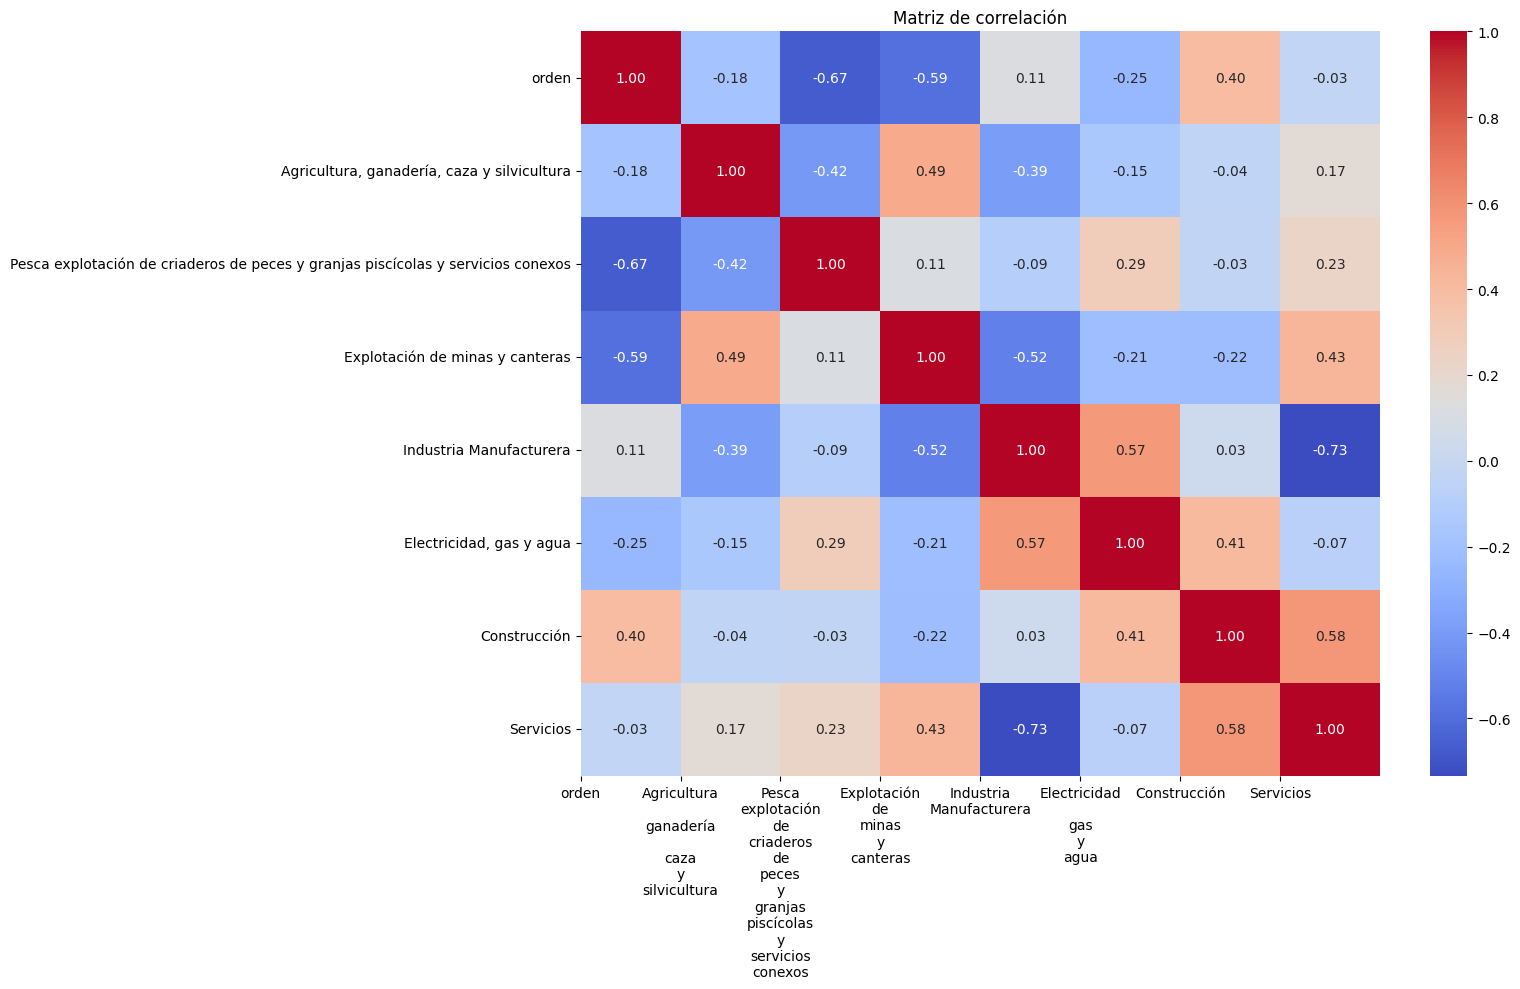

In [ ]:
# Correlacion entre variables
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.xticks(ticks=range(len(labels_wrapped)), labels=labels_wrapped, rotation=0)
plt.yticks(rotation=0)  # etiquetas verticales
plt.tight_layout()
plt.show()

En esta matriz se observa que algunas variables, como “Industria Manufacturera” y “Electricidad, gas y agua”, tienen una correlación positiva moderada (0.57), lo que indica que estas dos actividades tienden a aumentar o disminuir juntas. Por otro lado, “Industria Manufacturera” y “Servicios” muestran una correlación negativa fuerte (-0.73), lo que sugiere que cuando una variable aumenta, la otra tiende a disminuir.

También destaca que “Explotación de minas y canteras” tiene una correlación positiva moderada con “Servicios” (0.43) y una correlación negativa con “Industria Manufacturera” (-0.52), lo que puede reflejar diferencias en la dinámica económica entre estos sectores.

CONCLUSION

El dataset contiene un total de 45 variables o features y 613 entradas o registros. Estas variables incluyen tanto datos numéricos como categóricos.

En cuanto al tipo de datos, muchas columnas están clasificadas como objetos (object), lo que indica que son categóricas o texto. Sin embargo, algunas variables que deberían ser numéricas están almacenadas como texto, por lo que será necesario realizar conversiones para trabajar con datos cuantitativos continuos o discretos. También existen variables categóricas y posiblemente binarias dentro del conjunto.

Se detectaron algunas filas duplicadas, aunque en cantidad limitada, y también valores repetidos dentro de columnas, lo cual es común en datos categóricos pero debe ser evaluado en variables numéricas para evitar redundancias.

Respecto a los valores faltantes, varias columnas presentan datos incompletos, lo que implica que se deberá decidir cómo imputar esos valores o si es necesario eliminar registros o variables con muchos datos faltantes para mantener la calidad del análisis.

El análisis de distribución mediante histogramas y boxplots reveló que algunas variables presentan outliers o valores atípicos, especialmente la variable “orden”, mientras que otras variables muestran distribuciones más compactas y homogéneas.

La matriz de correlación indicó relaciones positivas y negativas entre ciertas variables, por ejemplo, una correlación positiva moderada entre “Industria Manufacturera” y “Electricidad, gas y agua”, y una correlación negativa fuerte entre “Industria Manufacturera” y “Servicios”. Estas relaciones ayudan a entender la interacción entre variables, identificar redundancias y seleccionar aquellas más relevantes para modelar o interpretar.

Respecto a las unidades, es importante revisar y estandarizar aquellas variables numéricas que puedan estar expresadas en diferentes escalas o formatos, para evitar sesgos en el análisis o modelado.